<a href="https://colab.research.google.com/github/TungLam111/gan-torch-technical-writing/blob/main/gan_torch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip '/content/gdrive/MyDrive/Lâm/archive.zip' 

Streaming output truncated to the last 5000 lines.
  inflating: animeface-character-dataset/data/face_323_149_22.png  
  inflating: animeface-character-dataset/data/face_323_149_25.png  
  inflating: animeface-character-dataset/data/face_323_149_32.png  
  inflating: animeface-character-dataset/data/face_323_149_38.png  
  inflating: animeface-character-dataset/data/face_323_149_56.png  
  inflating: animeface-character-dataset/data/face_323_149_7.png  
  inflating: animeface-character-dataset/data/face_323_149_81.png  
  inflating: animeface-character-dataset/data/face_323_174_148.png  
  inflating: animeface-character-dataset/data/face_323_174_151.png  
  inflating: animeface-character-dataset/data/face_323_174_154.png  
  inflating: animeface-character-dataset/data/face_323_174_44.png  
  inflating: animeface-character-dataset/data/face_323_174_52.png  
  inflating: animeface-character-dataset/data/face_323_174_54.png  
  inflating: animeface-character-dataset/data/face_323_174_92.p

In [ ]:
# diff
import torch
import torch.nn.functional as F

# train
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pdb
import os
import glob
from PIL import Image
from skimage.measure import label
import sys
import math
from numbers import Number

In [ ]:
def DiffAugment(x, policy='', channels_first=True):
    if policy:
        if not channels_first:
            x = x.permute(0, 3, 1, 2)
        for p in policy.split(','):
            for f in AUGMENT_FNS[p]:
                x = f(x)
        if not channels_first:
            x = x.permute(0, 2, 3, 1)
        x = x.contiguous()
    return x


def rand_brightness(x):
    x = x + (torch.rand(x.size(0), 1, 1, 1, dtype=x.dtype, device=x.device) - 0.5)
    return x


def rand_saturation(x):
    x_mean = x.mean(dim=1, keepdim=True)
    x = (x - x_mean) * (torch.rand(x.size(0), 1, 1, 1, dtype=x.dtype, device=x.device) * 2) + x_mean
    return x


def rand_contrast(x):
    x_mean = x.mean(dim=[1, 2, 3], keepdim=True)
    x = (x - x_mean) * (torch.rand(x.size(0), 1, 1, 1, dtype=x.dtype, device=x.device) + 0.5) + x_mean
    return x


def rand_translation(x, ratio=0.125):
    shift_x, shift_y = int(x.size(2) * ratio + 0.5), int(x.size(3) * ratio + 0.5)
    translation_x = torch.randint(-shift_x, shift_x + 1, size=[x.size(0), 1, 1], device=x.device)
    translation_y = torch.randint(-shift_y, shift_y + 1, size=[x.size(0), 1, 1], device=x.device)
    grid_batch, grid_x, grid_y = torch.meshgrid(
        torch.arange(x.size(0), dtype=torch.long, device=x.device),
        torch.arange(x.size(2), dtype=torch.long, device=x.device),
        torch.arange(x.size(3), dtype=torch.long, device=x.device),
    )
    grid_x = torch.clamp(grid_x + translation_x + 1, 0, x.size(2) + 1)
    grid_y = torch.clamp(grid_y + translation_y + 1, 0, x.size(3) + 1)
    x_pad = F.pad(x, [1, 1, 1, 1, 0, 0, 0, 0])
    x = x_pad.permute(0, 2, 3, 1).contiguous()[grid_batch, grid_x, grid_y].permute(0, 3, 1, 2)
    return x


def rand_cutout(x, ratio=0.5):
    cutout_size = int(x.size(2) * ratio + 0.5), int(x.size(3) * ratio + 0.5)
    offset_x = torch.randint(0, x.size(2) + (1 - cutout_size[0] % 2), size=[x.size(0), 1, 1], device=x.device)
    offset_y = torch.randint(0, x.size(3) + (1 - cutout_size[1] % 2), size=[x.size(0), 1, 1], device=x.device)
    grid_batch, grid_x, grid_y = torch.meshgrid(
        torch.arange(x.size(0), dtype=torch.long, device=x.device),
        torch.arange(cutout_size[0], dtype=torch.long, device=x.device),
        torch.arange(cutout_size[1], dtype=torch.long, device=x.device),
    )
    grid_x = torch.clamp(grid_x + offset_x - cutout_size[0] // 2, min=0, max=x.size(2) - 1)
    grid_y = torch.clamp(grid_y + offset_y - cutout_size[1] // 2, min=0, max=x.size(3) - 1)
    mask = torch.ones(x.size(0), x.size(2), x.size(3), dtype=x.dtype, device=x.device)
    mask[grid_batch, grid_x, grid_y] = 0
    x = x * mask.unsqueeze(1)
    return x


AUGMENT_FNS = {
    'color': [rand_brightness, rand_saturation, rand_contrast],
    'translation': [rand_translation],
    'cutout': [rand_cutout],
}

In [ ]:
class Generator(nn.Module):
    def __init__(self, opt):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(opt.nz, opt.ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(opt.ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(opt.ngf * 8, opt.ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(opt.ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(opt.ngf * 4, opt.ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(opt.ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(opt.ngf * 2, opt.ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(opt.ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(opt.ngf, opt.nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, z):
        return self.gen(z)

class Discriminator(nn.Module):
    def __init__(self, opt):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(opt.nc, opt.ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(opt.ndf, opt.ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(opt.ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(opt.ndf * 2, opt.ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(opt.ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(opt.ndf * 4, opt.ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(opt.ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(opt.ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
from torch.autograd import Variable

class NoiseLoss(torch.nn.Module):
  # need the scale for noise standard deviation
  # scale = noise  std
  def __init__(self, params, scale=None, observed=None):
    super(NoiseLoss, self).__init__()
    # initialize the distribution for each parameter
    #self.distributions = []
    self.noises = []
    for param in params:
      noise = 0*param.data # will fill with normal at each forward
      self.noises.append(noise)
    if scale is not None:
      self.scale = scale
    else:
      self.scale = 1.
    self.observed = observed

  def forward(self, params, scale=None, observed=None):
    # scale should be sqrt(2*alpha/eta)
    # where eta is the learning rate and alpha is the strength of drag term
    if scale is None:
      scale = self.scale
    if observed is None:
      observed = self.observed

    assert scale is not None, "Please provide scale"
    noise_loss = 0.0
    for noise, var in zip(self.noises, params):
      # This is scale * z^T*v
      # The derivative wrt v will become scale*z
      _noise = noise.normal_(0,1)
      noise_loss += scale*torch.sum(Variable(_noise)*var)
    noise_loss /= observed
    return noise_loss

class PriorLoss(torch.nn.Module):
  # negative log Gaussian prior
  def __init__(self, prior_std=1., observed=None):
    super(PriorLoss, self).__init__()
    self.observed = observed
    self.prior_std = prior_std

  def forward(self, params, observed=None):
    if observed is None:
      observed = self.observed
    prior_loss = 0.0
    for var in params:
      prior_loss += torch.sum(var*var/(self.prior_std*self.prior_std))
    prior_loss /= observed
    return prior_loss

In [ ]:
def pad_arr(arr):
    bg_val = sum(arr[0, 0])
    diff = max(arr.shape[:-1]) - min(arr.shape[:-1])
    diff_x, diff_y = int(np.floor(diff/2)), int(np.ceil(diff/2))
    idx_to_pad = np.argmin(arr.shape[:-1])

    if idx_to_pad == 0:
        pad_width = ((diff_x, diff_y), (0, 0), (0, 0))
    else:
        pad_width = ((0, 0), (diff_x, diff_y), (0, 0))

    # pdb.set_trace()
    pad = np.pad(arr, pad_width, 'constant', constant_values=bg_val)
    return pad


jpg_files = sorted(glob.glob("/content/data/new_data/*.JPG*"))
# png_files = sorted(glob.glob("./data/pokemon_/*.png*"))

for jpg in jpg_files:
# for jpg in png_files:
    jpg_im = Image.open(jpg)
    # pdb.set_trace()
    jpg_im = jpg_im.convert("RGBA")

    jpg_arr = np.array(jpg_im)
    if jpg_arr.shape[0] != jpg_arr.shape[1]:
        jpg_arr = pad_arr(jpg_arr)
    jpg_arr_ = np.sum(jpg_arr, axis=2)

    conn_region = label(jpg_arr_)

    bg = np.where(conn_region==1, 1, 0)
    bg = bg[:, :, np.newaxis]
    bg_re = np.repeat(bg, 4, axis=2)

    jpg_arr_nobg = np.where(bg_re, 0, jpg_arr)
    jpg_im_nobg = Image.fromarray(jpg_arr_nobg)

    if jpg_im_nobg.size[0] > 256:
        newsize = (256, 256)
        jpg_im_nobg_resize = jpg_im_nobg.resize(newsize)
        jpg_im_nobg_resize.save(os.path.join(os.path.dirname(jpg), os.path.basename(jpg)[:-4] + ".png"))
        # jpg_im.save(os.path.join(os.path.dirname(jpg), os.path.basename(jpg)[:-4] + ".png"))
        print(os.path.join(os.path.dirname(jpg), os.path.basename(jpg)[:-4] + ".png"), jpg_im_nobg_resize.size)
    # pdb.set_trace()

In [ ]:
#from png to jpg
png_files = sorted(glob.glob("/content/images/*.png*"))

for png in png_files:
    png_im = Image.open(png)
    png_im.load()

    background = Image.new("RGB", png_im.size, (255, 255, 255))
    background.paste(png_im, mask=png_im.split()[3])  # 3 is the alpha channel

    background.save(os.path.join(os.path.dirname(png), os.path.basename(png)[:-4] + ".jpg"), 'JPEG', quality=100)
    print(os.path.join(os.path.dirname(png), os.path.basename(png)[:-4] + ".jpg"), background.size)
    # pdb.set_trace()

In [ ]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


In [ ]:
parser = argparse.ArgumentParser()
dataroot="/content/animeface-character-dataset/animeface-character-dataset"
name="pokemon"
checkpoints_dir="/content/checkpoint"
parser.add_argument("--workers", type=int, default=2, help="Number of workers for dataloader")
parser.add_argument("--batch_size", type=int, default=32, help="Batch size during training")
parser.add_argument("--image_size", type=int, default=64, help="spatial size of training images. All images will be resized to this size")
parser.add_argument("--nc", type=int, default=3, help="Number of channels in the training images. For color images this is 3")
parser.add_argument("--nz", type=int, default=100, help="Size of z latent vector (i.e. size of generator input)")
parser.add_argument("--ngf", type=int, default=64, help="Size of feature maps in generator")
parser.add_argument("--ndf", type=int, default=64, help="Size of feature maps in discriminator")
parser.add_argument("--num_epochs", type=int, default=300, help="Number of training steps")
parser.add_argument("--lr", type=float, default=0.0002, help="adam: learning rate")
parser.add_argument("--b1", type=float, default=0.5, help="adam: decay of first order momentum of gradient")
parser.add_argument("--b2", type=float, default=0.999, help="adam: decay of first order momentum of gradient")
parser.add_argument("--aug_prob", type=float, default=0.6, help="probability of using Diff Augmentation during training")
parser.add_argument('--bayes', type=int, default=1, help='Do Bayesian GAN or normal GAN')
parser.add_argument('--gnoise_alpha', type=float, default=0.0001, help='')
parser.add_argument('--dnoise_alpha', type=float, default=0.0001, help='')

print("==============")
opt, args = parser.parse_known_args(sys.argv[1:])
print("==============")


In [ ]:
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                            transform=transforms.Compose([
                                transforms.Resize(opt.image_size),
                                transforms.CenterCrop(opt.image_size),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                            ]))

In [ ]:
# Set random seed for reproducibility
manualSeed = 999
# manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

ngpu = torch.cuda.device_count()


# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=opt.batch_size,
                                     shuffle=True, num_workers=opt.workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
# real_batch = next(iter(dataloader))
# plt.figure(figsize=(8,8))
# plt.axis("off")
# plt.title("Training Images")
# plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
# plt.show()

netG = Generator(opt).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    print("This activates on gpu")
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the G
print(netG)

netD = Discriminator(opt).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize the progression of the generator
fixed_noise = torch.randn(64, opt.nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
optimizerG = optim.Adam(netG.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))

# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
    # iters = 0
# since the log posterior is the average per sample, we also scale down the prior and the noise
# prior would be simulated enough times
gprior_criterion = PriorLoss(prior_std=1., observed=1000.)
gnoise_criterion = NoiseLoss(params=netG.parameters(), scale=math.sqrt(2*opt.gnoise_alpha/opt.lr), observed=1000.)
dprior_criterion = PriorLoss(prior_std=1., observed=50000.)
dnoise_criterion = NoiseLoss(params=netD.parameters(), scale=math.sqrt(2*opt.dnoise_alpha*opt.lr), observed=50000.)


Random Seed:  999
Generator(
  (gen): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1

In [ ]:
opt.num_epochs

300

Streaming output truncated to the last 5000 lines.
[139/300][221/305]	Loss_D: 0.3149	Loss_G: 8.3324	D(x): 0.8433	D(G(z)): 0.0124 / 0.0091
[139/300][231/305]	Loss_D: 0.1521	Loss_G: 7.2752	D(x): 0.9956	D(G(z)): 0.0445 / 0.0171
[139/300][241/305]	Loss_D: 0.6125	Loss_G: 4.9910	D(x): 0.7096	D(G(z)): 0.0924 / 0.1301
[139/300][251/305]	Loss_D: 1.3603	Loss_G: 10.2878	D(x): 0.9435	D(G(z)): 0.6122 / 0.0007
[139/300][261/305]	Loss_D: 0.3368	Loss_G: 8.3687	D(x): 0.8348	D(G(z)): 0.0049 / 0.0072
[139/300][271/305]	Loss_D: 0.2360	Loss_G: 6.2051	D(x): 0.9414	D(G(z)): 0.0637 / 0.0414
[139/300][281/305]	Loss_D: 0.2887	Loss_G: 6.7464	D(x): 0.8866	D(G(z)): 0.0521 / 0.0333
[139/300][291/305]	Loss_D: 0.2617	Loss_G: 6.3242	D(x): 0.9621	D(G(z)): 0.1082 / 0.0329
[139/300][301/305]	Loss_D: 0.2432	Loss_G: 7.0740	D(x): 0.9658	D(G(z)): 0.0767 / 0.0243
[140/300][1/305]	Loss_D: 0.3110	Loss_G: 7.4187	D(x): 0.9824	D(G(z)): 0.1575 / 0.0122
[140/300][11/305]	Loss_D: 0.8865	Loss_G: 10.1684	D(x): 0.9763	D(G(z)): 0.4629 / 

<Figure size 720x360 with 0 Axes>

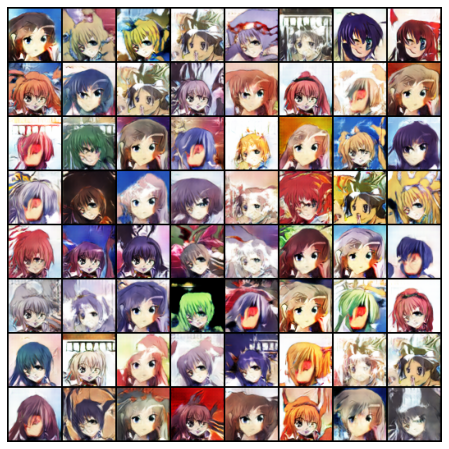

In [ ]:
print("Starting Training Loop...")
# For each epoch
for epoch in range(opt.num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
        rand_prob = np.random.uniform(0, 1)

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        if rand_prob < opt.aug_prob:
            real_cpu = DiffAugment(real_cpu, policy='color,translation,cutout')
           # plt.subplot(1, 2, 1)
           # plt.imshow(np.transpose(data[0][1].cpu().numpy(), axes=[1, 2, 0]))
           # plt.subplot(1, 2, 2)
           # plt.imshow(np.transpose(real_cpu[1].cpu().numpy(), axes=[1, 2, 0]))
           # plt.show()
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        label = label.to(dtype=torch.float)
    #label = torch.full((b_size,), label, device=device, dtype=torch.float)
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()
        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, opt.nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        if rand_prob < opt.aug_prob:
            fake = DiffAugment(fake, policy='color,translation,cutout')
            #plt.subplot(1, 2, 1)
            #plt.imshow(np.transpose(fake[0].cpu().detach().numpy(), axes=[1, 2, 0]))
            #plt.subplot(1, 2, 2)
            #plt.imshow(np.transpose(fake_aug[0].cpu().detach().numpy(), axes=[1, 2, 0]))
            #plt.show()

        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        if opt.bayes:
            errD_prior = dprior_criterion(netD.parameters())
            errD_prior.backward()
            errD_noise = dnoise_criterion(netD.parameters())
            errD_noise.backward()
            errD = errD_real + errD_fake + errD_prior + errD_noise
        # Add the gradients from the all-real and all-fake batches
        else :
            errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        if opt.bayes:
           errG += gprior_criterion(netG.parameters())
           errG += gnoise_criterion(netG.parameters())
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 10 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                      % (epoch+1, opt.num_epochs, i+1, len(dataloader),
                         errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

    if epoch % 5 == 0 or epoch == opt.num_epochs - 1:
        state = {'epoch_done': epoch, 'opt': opt, 'weight': netG.state_dict()}
        torch.save(state, "%s/%s/saved_models/generator_%d.pth" % ("checkpoint", name, epoch))
        torch.save(netD.state_dict(),
                       "%s/%s/saved_models/discriminator_%d.pth" % ("checkpoint", name, epoch))

        # Check how the generator is doing by saving G's output on fixed_noise
        with torch.no_grad():
            fake = netG(fixed_noise).detach().cpu()
        img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
        vutils.save_image(fake, "%s/%s/images/%d.jpg" % ("checkpoint", name, epoch))


plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, label="G")
plt.plot(D_losses, label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig(os.path.join("checkpoint", name, 'loss.jpg'))
plt.clf()

fig = plt.figure(figsize=(8, 8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i, (1, 2, 0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
ani.save(os.path.join("checkpoint", name, 'progress.mp4'))

<Figure size 720x360 with 0 Axes>

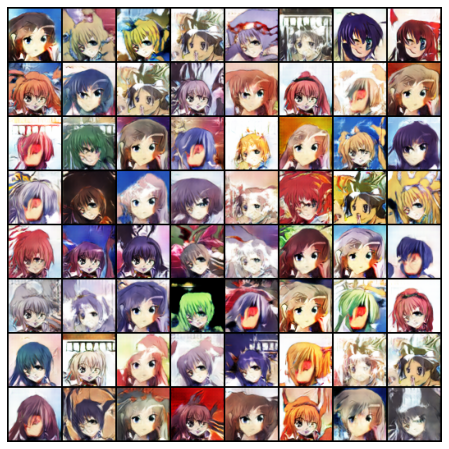

In [ ]:
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, label="G")
plt.plot(D_losses, label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig(os.path.join("checkpoint", name, 'loss.jpg'))
plt.clf()

fig = plt.figure(figsize=(8, 8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i, (1, 2, 0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
ani.save(os.path.join("checkpoint", name, 'progress.mp4'))

In [ ]:

'''Generate images from saved checkpoints'''

name ="pokemon2"
checkpoints_dir="/content/checkpoint"
n_image=50

# Set random seed for reproducibility
manualSeed = 999
# manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

device = torch.device("cuda:0")

fixed_noise = torch.randn(n_image, 100, 1, 1)

g_checkpoints = glob.glob(os.path.join("checkpoint", "pokemon/saved_models", "generator*"))
print(g_checkpoints)
for checkpoint in ["checkpoint/pokemon/saved_models/generator_99.pth"]:
    print(checkpoint)
    gen_state = torch.load(checkpoint)
    opt = gen_state['opt']
    netG = Generator(opt).to()
    netG.load_state_dict(gen_state.get('weight', False))
    netG.eval()
    savedir = "%s/%s/generated/%s" % ("checkpoint", name, os.path.basename(checkpoint).split('.')[0])
    os.makedirs(savedir, exist_ok=True)

    with torch.no_grad():
        for i in range(fixed_noise.size(0)): 
            fakegen = netG(fixed_noise[i:i+1])
            print(fakegen)
            fake = (fakegen * 0.5 + 0.5) * 255
            im = Image.fromarray(np.transpose(fake[0].cpu().numpy().astype(np.uint8), axes=[1, 2, 0]))
            im.save(os.path.join(savedir, str(i) + ".jpeg"))

    print(savedir, 'finished')

In [ ]:
len(g_checkpoints)

62